> **Essential ML process for Intrusion Detection**
<br>`NOTE: as of June 2022 {python3.8 numpy 1.19.5} are max versions for conda tensorflow builds 2.2-2.6 (at least) - seems like the pip build works with numpy >= 1.20 but pip install breaks the consistency of the conda environment`

**Import the main libraries**

In [15]:
import numpy
import pandas

from time import time
trs = time()

import os
data_path = '../datasets/NSL_KDD'

**Import the Dataset**

In [16]:
# Using boosted Train and preprocessed Test

data_file = os.path.join(data_path, 'NSL_boosted-1.csv') 
train_df = pandas.read_csv(data_file)
print('Train Dataset: {} rows, {} columns'.format(train_df.shape[0], train_df.shape[1]))

data_file = os.path.join(data_path, 'NSL_ppTest.csv') 
test_df = pandas.read_csv(data_file)
print('Test Dataset: {} rows, {} columns'.format(test_df.shape[0], test_df.shape[1]))

Train Dataset: 63280 rows, 43 columns
Test Dataset: 22544 rows, 43 columns


***
**Data Preparation and EDA** (unique to this dataset)

* _let's skip the Checking (EDA)_

* _Combine for processing classification target and text features_

In [17]:
combined_df = pandas.concat([train_df, test_df])
print('Combined Dataset: {} rows, {} columns'.format(
    combined_df.shape[0], combined_df.shape[1]))

Combined Dataset: 85824 rows, 43 columns


* _Classification Target feature:_
two columns of labels are available 
    * Two-class: Reduce the detailed attack labels to 'normal' or 'attack'
    * Multiclass: Use the category labels (atakcat)

In [18]:
# Set the classification target
twoclass = False     # True or False

In [19]:
if twoclass:
# Two-class: Reduce the detailed attack labels to 'normal' or 'attack'
# new single column data structure is a [series]
    labels_df = combined_df['label'].copy()
    labels_df[labels_df != 'normal'] = 'attack'
else:
# Multiclass: Use the category labels (atakcat)
# new single column data structure is a [[dataframe]]
# rename the column and convert to a series for later
    labels_df = combined_df[['atakcat']].copy()
    labels_df.rename(columns={'atakcat':'label'}, inplace=True)
    labels_df = labels_df.squeeze('columns')

# drop target features 
combined_df.drop(['label'], axis=1, inplace=True)
combined_df.drop(['atakcat'], axis=1, inplace=True)

In [20]:
# generate a list of numeric columns for scaling (later)
numeri = combined_df.select_dtypes(include=['float64','int64']).columns
print(numeri.to_list())

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


* _One-Hot Encoding the remaining categorical (text) features_

In [21]:
# put the names into a python list - for pandas.get_dummies()
categori = combined_df.select_dtypes(include=['object']).columns
category_cols = categori.tolist()
print(category_cols)

['protocol_type', 'service', 'flag']


In [22]:
# Apply to the list of Categorical columns (text fields)
features_df = pandas.get_dummies(combined_df, columns=category_cols)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85824 entries, 0 to 22543
Columns: 120 entries, duration to flag_SH
dtypes: float64(15), int64(23), uint8(82)
memory usage: 32.2 MB


***
**<br>Create Test // Train Datasets**
> Normally we split the dataset into train 70 % // test 30 % like this
<br>`from sklearn.model_selection import train_test_split`
<br>`X_train, X_test, y_train, y_test = `
<br>`    train_test_split(features_df, labels_df, `
<br>`        test_size=0.3, stratify=labels_df, random_state=42)`

In [23]:
# Restore the train // test split: slice 1 Dataframe into 2 
# pandas has a lot of rules about returning a 'view' vs. a copy from slice
# so we force it to create a new dataframe [avoiding SettingWithCopy Warning]
features_train = features_df.iloc[:len(train_df),:].copy()    # X_train
features_test = features_df.iloc[len(train_df):,:].copy()     # X_test

# Restore the train // test split: slice 1 Series into 2 
labels_train = labels_df[:len(train_df)]               # y_train
labels_test = labels_df[len(train_df):]                # y_test

***
Next are standard steps for all datasets: _scaling, classifiers, results_

**Scaling** comes _after_ test // train split

In [24]:
# scaling the Numeric columns 
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# StandardScaler range: -1 to 1, MinMaxScaler range: zero to 1
# ColumnTransformer returns a numpy.ndarray so we lose the feature names;
# we process one column at a time to preserve the dataframe

# sklearn docs say 
#   "Don't cheat - fit only on training data, then transform both"
#   fit() expects 2D array: reshape(-1, 1) for single col or (1, -1) single row

for i in numeri:
    arr = numpy.array(features_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    features_train[i] = scale.transform(arr.reshape(len(arr),1))

    arr = numpy.array(features_test[i])
    features_test[i] = scale.transform(arr.reshape(len(arr),1))

**<br>Function** to calculate perfomance metrics

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

In [26]:
def show_metrics(y_test,ygx,lbls):
    tptn_df = pandas.DataFrame(confusion_matrix(y_test, ygx, labels=lbls), 
                           index=['train:{:}'.format(x) for x in lbls], 
                           columns=['pred:{:}'.format(x) for x in lbls])
    print(tptn_df)    
    print("\n~~~~")
    
    TP = numpy.diag(tptn_df.values)
    FP = tptn_df.values.sum(axis=0) - TP
    FN = tptn_df.values.sum(axis=1) - TP
    TN = numpy.sum(tptn_df.values) - (FP + FN + TP)
# false positive rates
    FPR = FP/(FP+TN)
# false negative rates
    FNR = FN/(TP+FN)
# overall 
    sfpr=FP.sum()/(FP.sum()+TN.sum())
    sfnr=FN.sum()/(TP.sum()+FN.sum())
    
    if len(lbls) >2:
        for x in range(len(lbls)):
            print('{:>12} : '.format(lbls[x]),
                  'FPR = %.3f   FNR = %.3f' % (FPR[x], FNR[x]))
        print()

    print('{:>12} : '.format('macro avg'),
          'FPR = %.3f   FNR = %.3f'  % (FPR.mean(), FNR.mean()))
    print('weighted avg :  FPR = %.3f   FNR = %.3f' % (sfpr, sfnr))
 
    print("\n~~~~")
    
#    macro average: unweighted mean per label 
# weighted average: support-weighted mean per label  
    print(classification_report(y_test, ygx, digits=3, target_names=lbls))

    print("~~~~")
# Matthews correlation coefficient: 
#   correlation between prediction and ground truth
#   (+1 perfect, 0 random prediction, -1 inverse)

    mcc = matthews_corrcoef(y_test, ygx)
    print('MCC: Overall :  %.3f' % mcc)
    if len(lbls) >2:
        for tc in lbls:
            bin_mcc = matthews_corrcoef(y_test == tc, ygx == tc)
            print('{:>12} :'.format(tc),' %.3f' % bin_mcc)  

    return '~~~~'

**<br>Target Label Distributions**

In [27]:
# shape method gives the dimensions of the dataset
print('features_train: {} rows, {} columns'.format(features_train.shape[0], features_train.shape[1]))
print('features_test:  {} rows, {} columns'.format(features_test.shape[0], features_test.shape[1]))
print()
print('labels_train: {} rows, 1 column'.format(labels_train.shape[0]))
print('labels_test:  {} rows, 1 column'.format(labels_test.shape[0]))
print()

## Here's a nice report:  
# 1. series to dataframe conversion
my_train = pandas.DataFrame(labels_train)
my_test = pandas.DataFrame(labels_test)
# 2. dataframe copy with [[ -- ]]
av_train = my_train[['label']].apply(lambda x: x.value_counts())
av_test = my_test[['label']].apply(lambda x: x.value_counts())
# 3. add a new column
av_train['pct_train'] = round((100 * av_train / av_train.sum()),2)
av_test['pct_test'] = round((100 * av_test / av_test.sum()),2)
# 4. combine the dataframes
av_tt = pandas.concat([av_train,av_test], axis=1) 
# 5. print the report
print('Frequency and Distribution of labels')
print(av_tt)

features_train: 63280 rows, 120 columns
features_test:  22544 rows, 120 columns

labels_train: 63280 rows, 1 column
labels_test:  22544 rows, 1 column

Frequency and Distribution of labels
        label  pct_train  label  pct_test
benign  33671      53.21   9711     43.08
dos     23066      36.45   7458     33.08
probe    5907       9.33   2421     10.74
r2l       578       0.91   2754     12.22
u2r        58       0.09    200      0.89


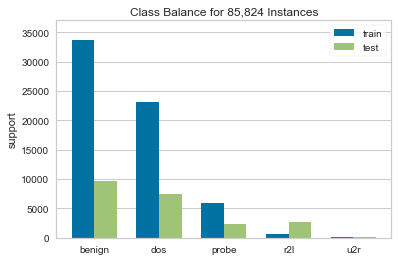

In [28]:
from yellowbrick.target import ClassBalance
# The ClassBalance visualizer has a “compare” mode, 
#   to create a side-by-side bar chart instead of a single bar chart 

# Instantiate the visualizer
visualizer = ClassBalance()
visualizer.fit(labels_train,labels_test)        # Fit the data to the visualizer
_ = visualizer.show()                  # Finalize and render the figure
# assign visualizer.show() to a null variable to avoid printing some trash

**<br>Classifier Selection<br>Fit and Predict**

**<br>Tensorflow.Keras Model**

In [29]:
import tensorflow as tf

In [30]:
# requires numeric labels
from sklearn.preprocessing import LabelEncoder

## Feature being predicted ("the Right Answer")
ytrain = LabelEncoder().fit_transform(labels_train)
ytest = LabelEncoder().fit_transform(labels_test)

In [31]:
X_train = features_train
X_test = features_test
y_train = ytrain
y_test = ytest

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((63280, 120), (22544, 120), (63280,), (22544,))

In [32]:
# Essential Hyperparameters
CLASSES = 5          # output layer size
EPOCHS = 10          # max runs through the network
BATCH_SIZE = 256     # training data subset size

***
**Define the model**

In [33]:
# shape for initial input tensor depends on first layer
# feed_forward shape ... SKIP THE RESHAPE!
shape = (X_train.shape[1])

In [34]:
X_train.shape, X_test.shape, shape

((63280, 120), (22544, 120), 120)

In [35]:
# NO Spaces in names
model_name = 'feed_forward'

model = tf.keras.Sequential()
# feed_forward shape ...
model.add(tf.keras.layers.InputLayer(input_shape=shape, name='optionalLayer'))

model.add(tf.keras.layers.Dense(100, activation='relu', name='InitialLayer'))
model.add(tf.keras.layers.Dense(50, activation='relu', name='mid_Layer'))
model.add(tf.keras.layers.Dense(25, activation='relu', name="mid-Layer"))
model.add(tf.keras.layers.Dense(CLASSES, name="OutputLayer"))
model.add(tf.keras.layers.Softmax(name="ResultLayer"))

 ***

**<br>Below works for any model**

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InitialLayer (Dense)         (None, 100)               12100     
_________________________________________________________________
mid_Layer (Dense)            (None, 50)                5050      
_________________________________________________________________
mid-Layer (Dense)            (None, 25)                1275      
_________________________________________________________________
OutputLayer (Dense)          (None, 5)                 130       
_________________________________________________________________
ResultLayer (Softmax)        (None, 5)                 0         
Total params: 18,555
Trainable params: 18,555
Non-trainable params: 0
_________________________________________________________________


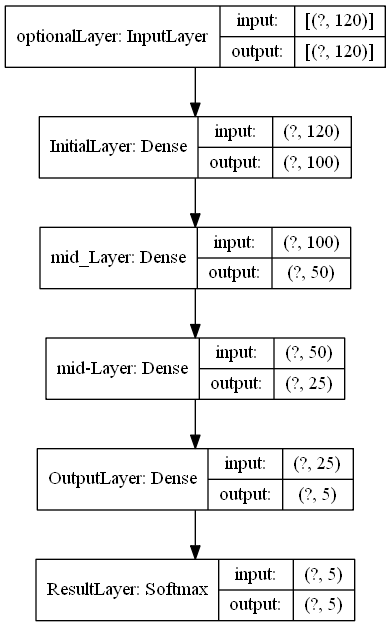

In [37]:
# saves a picture of the model to results
# rankdir 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
tf.keras.utils.plot_model(model, 
                          f'{model_name}_graph.png', 
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB')

In [38]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = "adam",
              metrics = ['acc','mse']
             )

In [ ]:
# stop the training when there is no improvement 
# in the loss for five consecutive epochs

#from tensorflow.keras.callbacks import EarlyStopping
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
#                        patience=5, verbose=1, mode='auto', 
#                        restore_best_weights=True)

In [39]:
hist = model.fit(X_train, y_train, 
                 epochs=EPOCHS, 
                 batch_size = BATCH_SIZE,
                 # validation_data=(X_test,y_test),
                 validation_split = .15,
                 # callbacks=[monitor],
                 shuffle = True
                )

Epoch 1/10
211/211 [==============================] - 3s 12ms/step - loss: 0.2534 - acc: 0.9434 - mse: 0.7537 - val_loss: 0.1766 - val_acc: 0.9568 - val_mse: 0.8724
Epoch 2/10
211/211 [==============================] - 2s 10ms/step - loss: 0.0573 - acc: 0.9800 - mse: 0.7803 - val_loss: 0.1893 - val_acc: 0.9618 - val_mse: 0.8756
Epoch 3/10
211/211 [==============================] - 2s 11ms/step - loss: 0.0426 - acc: 0.9860 - mse: 0.7823 - val_loss: 0.1987 - val_acc: 0.9638 - val_mse: 0.8738
Epoch 4/10
211/211 [==============================] - 2s 10ms/step - loss: 0.0355 - acc: 0.9880 - mse: 0.7832 - val_loss: 0.2256 - val_acc: 0.9647 - val_mse: 0.8782
Epoch 5/10
211/211 [==============================] - 2s 10ms/step - loss: 0.0302 - acc: 0.9904 - mse: 0.7839 - val_loss: 0.2174 - val_acc: 0.9676 - val_mse: 0.8783
Epoch 6/10
211/211 [==============================] - 2s 11ms/step - loss: 0.0264 - acc: 0.9910 - mse: 0.7844 - val_loss: 0.2103 - val_acc: 0.9694 - val_mse: 0.8784
Epoch 7/10

**<br>Standard Tensorrflow Metrics**

In [40]:
# Verbosity mode. 0 = silent, 1 = progress bar, 2 = single line
train_loss, train_accuracy, train_mse = model.evaluate(X_train,  y_train, verbose=1)
test_loss, test_accuracy, test_mse = model.evaluate(X_test,  y_test, verbose=1)

#print('Elapsed %.3f seconds.' % elapsed)
print('****** TRAIN ******')
print('Loss : %.4f   Accuracy : %.4f' % (train_loss, train_accuracy))
#print(f"Loss: {train_loss}\nAccuracy: {train_accuracy}")
print('****** TEST ******')
print('Loss : %.4f   Accuracy : %.4f' % (test_loss, test_accuracy))
#print('Loss :  %.3f' % test_loss)
#print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")

705/705 [==============================] - 3s 4ms/step - loss: 1.9168 - acc: 0.7754 - mse: 1.8152
****** TRAIN ******
Loss : 0.0496   Accuracy : 0.9908
****** TEST ******
Loss : 1.9168   Accuracy : 0.7754


In [41]:
import matplotlib.pyplot as plt
#import seaborn as sns

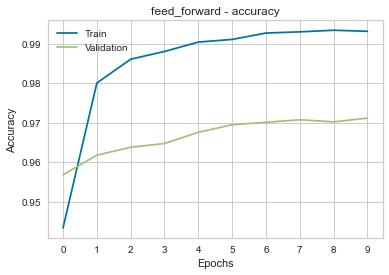

In [42]:
#plt.figure(figsize = (20,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label='Validation')
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Accuracy")
plt.legend()
plt.title(f'{model_name} - accuracy')
#plt.savefig(f'{model_name}_accuracy.png')
plt.show()

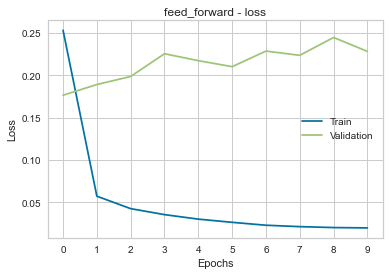

In [43]:
#plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(EPOCHS)])
plt.ylabel("Loss")
plt.legend()
plt.title(f'{model_name} - loss')
#plt.savefig(f'{model_name}_loss.png')
plt.show()

**<br>Convert everything back to text labels for our metrics function**

In [44]:
y_pred = model.predict([X_test])
predictions = y_pred.argmax(axis=-1)

In [45]:
## Generate a sorted list of unique labels
from sklearn.utils.multiclass import unique_labels
ll_test = pandas.DataFrame(labels_test)
clss = unique_labels(ll_test['label'])

## convert predictions and 'ground truth'
ll_pred = pandas.DataFrame(predictions)
ll_pred[0] = ll_pred[0].apply(lambda x: clss[x])

ll_ytst = pandas.DataFrame(y_test)
ll_ytst[0] = ll_ytst[0].apply(lambda x: clss[x])

print("\n~~~~")
print('Confusion Matrix:', model_name)
show_metrics(ll_ytst,ll_pred,clss)


~~~~
Confusion Matrix: feed_forward
              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         9258        71         378         3         1
train:dos            1240      6172          36        10         0
train:probe           404       233        1734        50         0
train:r2l            2448         1           7       298         0
train:u2r             157         1          17         6        19

~~~~
      benign :  FPR = 0.331   FNR = 0.047
         dos :  FPR = 0.020   FNR = 0.172
       probe :  FPR = 0.022   FNR = 0.284
         r2l :  FPR = 0.003   FNR = 0.892
         u2r :  FPR = 0.000   FNR = 0.905

   macro avg :  FPR = 0.075   FNR = 0.460
weighted avg :  FPR = 0.056   FNR = 0.225

~~~~
              precision    recall  f1-score   support

      benign      0.685     0.953     0.797      9711
         dos      0.953     0.828     0.886      7458
       probe      0.798     0.716     0.755      2421
         r2l      0.812     0.1

'~~~~'